In [ ]:
#CODE TO SETUP WANDB

!pip install wandb
 
import wandb
from wandb.keras import WandbCallback

# wandb.login()

In [ ]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
#import Tensorflow namespaces

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from sklearn.preprocessing import StandardScaler
import pickle
from random import randint
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
#Creating dataset and scale to value between 0 and 1
IMG_WIDTH=64
IMG_HEIGHT=64
def create_dataset(img_folder):
    images_data=[]
    labels=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image = np.array(Image.open(image_path))
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255
            images_data.append(image)
            labels.append(dir1)
    return images_data,labels

In [ ]:
path_images='images' #Unzip first :)

images_data,labels=create_dataset(path_images)

In [ ]:
#Categorizes the labels
labels=pd.Categorical(labels)
labels=labels.codes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


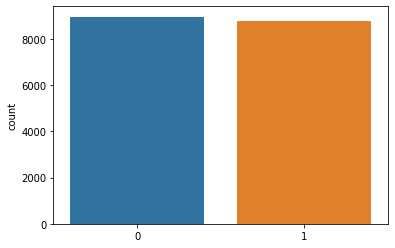

In [ ]:
sns.countplot(labels)
#The dataset is very balanced, making it easier to train the model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_data, labels, test_size=0.30, random_state=42, stratify=labels)

In [ ]:
# Custom CNN classifier
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols,3)
adam = tf.keras.optimizers.Adam(0.01035)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
model = Sequential()

model.add(Conv2D(256, kernel_size=(3, 3), input_shape=input_shape)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
model.add(Conv2D(128, kernel_size=(3, 3))) 
model.add(BatchNormalization())
model.add(Activation('relu'))      
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
model.add(Conv2D(64, kernel_size=(3, 3))) 
model.add(BatchNormalization())
model.add(Activation('relu'))      
model.add(MaxPooling2D(pool_size=(2, 2)))
#-----------------------------------------------
model.add(Flatten()) 
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu')) 
model.add(Dropout(0.4))
#-----------------------------------------------
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])

# Trainen van het CNN
history = model.fit(np.array(X_train),y_train,batch_size=16, epochs=50, validation_split=0.2, verbose=1, callbacks=[es])
loss, accuracy = model.evaluate(np.array(X_test), y_test)

### WANDB


In [ ]:
# Setting up the model to start hyperparameter tuning
def train():
    run = wandb.init(project='Car-Detection',
                    config={  # and include hyperparameters and metadata
                        "learning_rate": 0.01035,
                        "epochs": 50,
                        "batch_size": 16,
                        "dropoutrate":0.4,
                        "activation_hidden": 'relu' ,
                        "activation_output": 'sigmoid',
                        "loss_function": "binary_crossentropy",
                        "architecture": "CNN",
                        "dataset": "Cars"
                    })
    
    config = wandb.config
    img_rows, img_cols = 64, 64
    input_shape = (img_rows, img_cols,3)
    adam = tf.keras.optimizers.Adam(config.learning_rate)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    model = Sequential()

    model.add(Conv2D(256, kernel_size=(3, 3), input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation(config.activation_hidden))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #-----------------------------------------------
    model.add(Conv2D(128, kernel_size=(3, 3))) 
    model.add(BatchNormalization())
    model.add(Activation(config.activation_hidden))      
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #-----------------------------------------------
    model.add(Conv2D(64, kernel_size=(3, 3))) 
    model.add(BatchNormalization())
    model.add(Activation(config.activation_hidden))      
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #-----------------------------------------------
    model.add(Flatten()) 
    model.add(Dropout(config.dropoutrate))
    model.add(Dense(32, activation=config.activation_hidden)) 
    model.add(Dropout(config.dropoutrate))
    model.add(Dense(1, activation=config.activation_output))

    model.compile(loss=config.loss_function,
                optimizer=adam,
                metrics=['accuracy'])

    # Training CNN
    history = model.fit(np.array(X_train),y_train,batch_size=config.batch_size, epochs=config.epochs, validation_split=0.2, verbose=1, callbacks=[WandbCallback(),es])
    # Evaluate    
    loss, accuracy = model.evaluate(np.array(X_test), y_test)
    wandb.log({'Test loss': loss, 'Test accuracy': accuracy})
    return model, history,run

In [ ]:
model, history,run=train()
run.finish()

In [ ]:
sweep_config = {
  'method': 'random', 
  'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
  },
  'parameters': {
      'batch_size': {
          'values': [8, 16, 32, 64, 128, 256]
      },
      'learning_rate':{
          'min': 0.00001,
          'max': 0.1
      },
      'dropoutrate':{
          'values': [0.1, 0.2, 0.3,0.4]
      },
  },
  'early_terminate':{
      'type': 'hyperband',
      'min_iter': 5
    }
}

sweep_id = wandb.sweep(sweep_config, project="Car-Detection")
wandb.agent(sweep_id, function=train)
# Hyperparameter tuning with wandb sweeps, making it easy to try different combinations of hyperparameters.

## Test evaluation

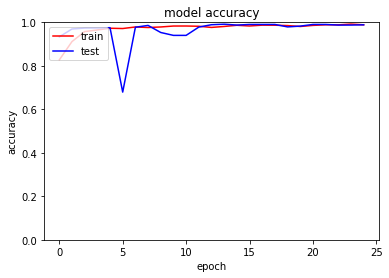

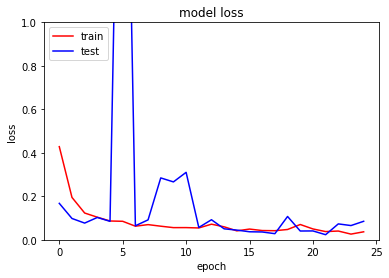

In [ ]:
# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()
#With this "ideal" dataset we can see the model performs very well.

In [ ]:
y_pred = model.predict_classes(np.array(X_test))
print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 
#With this "ideal" dataset we can see the model performs very well.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '




              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2690
           1       1.00      0.98      0.99      2641

    accuracy                           0.99      5331
   macro avg       0.99      0.99      0.99      5331
weighted avg       0.99      0.99      0.99      5331

[[2684    6]
 [  57 2584]]
98.8182329769274


### VGG19

In [ ]:
# using the pretrained VGG19 classifier to improve the model even more
modelVGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(64,64,3))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
model = Sequential()

for layer in modelVGG19.layers[:]:
    model.add(layer)

for layer in model.layers:
    layer.trainable = False

# Add custom dense layers

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))

adam = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',optimizer =adam,metrics=['accuracy'])
history = model.fit(np.array(X_train), y_train, batch_size=16,  shuffle= True,validation_split=0.2, epochs=5, verbose=1,callbacks=[es])
model.save('vgg_model.h5')

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/5
622/622 [==============================] - 53s 36ms/step - loss: 0.0792 - accuracy: 0.9720 - val_loss: 0.0474 - val_accuracy: 0.9863
Epoch 2/5
622/622 [==============================] - 21s 34ms/step - loss: 0.0412 - accuracy: 0.9869 - val_loss: 0.0175 - val_accuracy: 0.9924
Epoch 3/5
622/622 [==============================] - 21s 34ms/step - loss: 0.0344 - accuracy: 0.9892 - val_loss: 0.0216 - val_accuracy: 0.9928
Epoch 4/5
622/622 [==============================] - 21s 34ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0132 - val_accuracy: 0.9956
Epoch 5/5
622/622 [==============================] - 21s 34ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0438 - val_accuracy: 0.9847


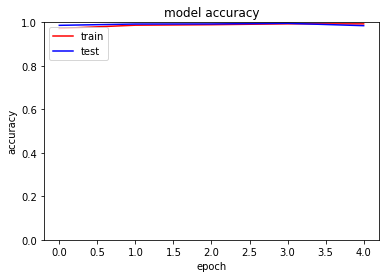

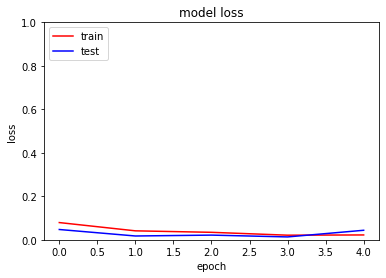

In [ ]:
# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
y_pred = model.predict_classes(np.array(X_test))
print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 
#With the pretrained model the performance is even higher.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '




              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2690
           1       1.00      0.99      0.99      2641

    accuracy                           0.99      5331
   macro avg       0.99      0.99      0.99      5331
weighted avg       0.99      0.99      0.99      5331

[[2688    2]
 [  32 2609]]
99.36222097167511


In [ ]:
model = tf.keras.models.load_model('vgg_model.h5')

In [ ]:
# Making a sliding window to detect objects. This is done for experimenting purposes. YOLO should be used for real time detection.
filename= 'StreetImages/street2.jpg'
image = np.array(Image.open(filename))
orginal_w=image.shape[1]
orginal_h=image.shape[0]
image=cv2.resize(image, (math.floor(image.shape[1]/64)*64,math.floor(image.shape[0]/64)*64),interpolation = cv2.INTER_AREA)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


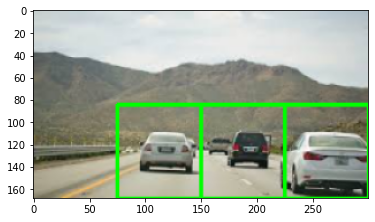

In [ ]:
# Making a sliding window to detect objects. This is done for experimenting purposes. YOLO should be used for real time detection.
window_width=64
window_height=64
windowSize=(WinW, WinH)
stepSize=64
for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
        window= image[y:y + windowSize[1], x:x + windowSize[0]]
        window = window.astype('float32')
        window /=255
        window = np.expand_dims(window,axis=0)
        pred= model.predict_classes(window)
        if pred:
            cv2.rectangle(image, (x, y), (x + window_width, y + window_height), (0, 255, 0), 2)
image=cv2.resize(image, (orginal_w,orginal_h),interpolation = cv2.INTER_AREA)
plt.imshow(np.array(image).astype('uint8'))
plt.show()